<a href="https://colab.research.google.com/github/Rys053/Test/blob/main/Household_Electric_Power_Consumption_prediction_with_Transformer_upgrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
Path to dataset files: /kaggle/input/electric-power-consumption-data-set


In [4]:
data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt",
                   sep=';', parse_dates={'datetime':['Date','Time']}, infer_datetime_format=True,
                   na_values=['?'], low_memory=False)

/tmp/ipython-input-3782930499.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt",
/tmp/ipython-input-3782930499.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt",
/tmp/ipython-input-3782930499.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_

In [6]:
features = ['Global_active_power','Global_reactive_power','Voltage']
data = data[['datetime'] + features].dropna()
for col in features:
    data[col] = data[col].astype(float)

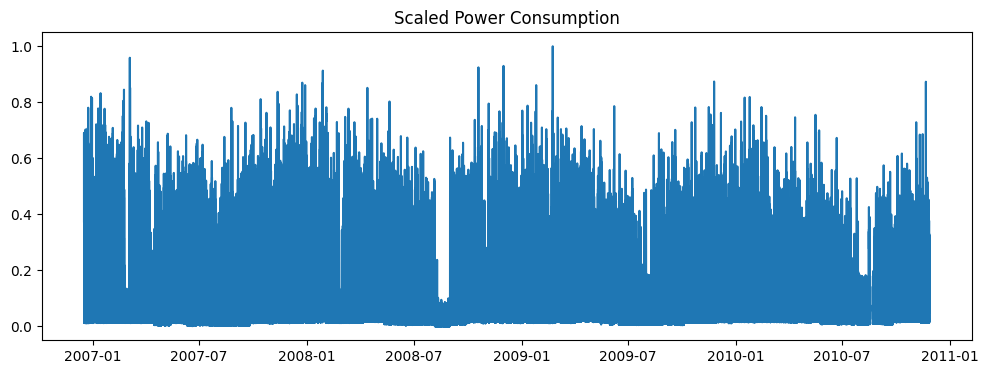

In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])
series = data_scaled  # shape: (num_timesteps, num_features)

plt.figure(figsize=(12,4))
plt.plot(data['datetime'], series[:,0], label='Global_active_power')
plt.title("Scaled Power Consumption")
plt.show()

In [9]:
class MultiVarTimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len=48, pred_len=3):
        self.series = series
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.series) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.seq_len]
        y = self.series[idx+self.seq_len:idx+self.seq_len+self.pred_len, 0]  # 첫 번째 feature 예측
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [10]:
seq_len = 48  # 과거 48시간
pred_len = 3  # 다음 3시간 예측
dataset = MultiVarTimeSeriesDataset(series, seq_len, pred_len)

train_size = int(len(dataset)*0.8)
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [13]:
class TransformerForecastAdvanced(nn.Module):
    def __init__(self, input_dim=3, d_model=64, nhead=4, num_layers=2, dropout=0.1, pred_len=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, pred_len)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        x = self.transformer(x)
        x = self.layer_norm(x[-1,:,:])
        out = self.decoder(x)
        return out

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerForecastAdvanced(input_dim=len(features), pred_len=pred_len).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Train Loss: {total_loss/len(train_loader):.6f}")

Epoch [1/20] Avg Train Loss: 0.001700


Epoch [2/20] Avg Train Loss: 0.001148


Epoch [3/20] Avg Train Loss: 0.001102


Epoch [4/20] Avg Train Loss: 0.001081


Epoch [5/20] Avg Train Loss: 0.001065


Epoch [6/20] Avg Train Loss: 0.001055


Epoch [7/20] Avg Train Loss: 0.001046


Epoch [8/20] Avg Train Loss: 0.001040


Epoch [9/20] Avg Train Loss: 0.001035


Epoch [10/20] Avg Train Loss: 0.001030


Epoch [11/20] Avg Train Loss: 0.001026


Epoch [12/20] Avg Train Loss: 0.001022


Epoch [13/20] Avg Train Loss: 0.001019


Epoch [14/20] Avg Train Loss: 0.001016


Epoch [15/20] Avg Train Loss: 0.001015


Epoch [16/20] Avg Train Loss: 0.001013


Epoch [17/20] Avg Train Loss: 0.001011


Epoch [18/20] Avg Train Loss: 0.001009


Epoch [19/20] Avg Train Loss: 0.001007


Epoch [20/20] Avg Train Loss: 0.001005


In [16]:
def evaluate_rmse(model, data_loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            preds.append(y_pred.cpu().numpy())
            trues.append(y_batch.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    return rmse, trues, preds

rmse, trues, preds = evaluate_rmse(model, val_loader, device)
print(f"Validation RMSE: {rmse:.6f}")

Validation RMSE: 0.026460


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


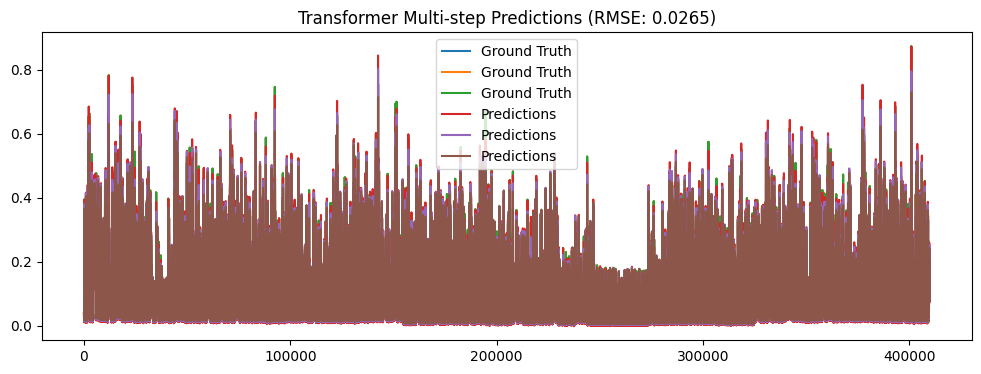

In [17]:
plt.figure(figsize=(12,4))
plt.plot(trues, label='Ground Truth')
plt.plot(preds, label='Predictions')
plt.title(f"Transformer Multi-step Predictions (RMSE: {rmse:.4f})")
plt.legend()
plt.show()